# Лабораторная работа 2 

# Распознавание именованных сущностей из Twitter с помощью LSTM

### Бобряков А.С.

## Введение

### Постановка задачи

В этом задании вы будете использовать рекуррентные нейронные сети для решения проблемы распознавания именованных сущностей (NER). Примерами именованных сущностей являются имена людей, названия организаций, адреса и т.д. В этом задании вы будете работать с данными twitter.

Например, вы хотите извлечь имена и названия организаций. Тогда для текста

    Yan Goodfellow works for Google Brain

модель должна извлечь следующую последовательность:

    B-PER I-PER    O     O   B-ORG  I-ORG

где префиксы *B-* и *I-* означают начало и конец именованной сущности, *O* означает слово без тега. Такая префиксная система введена, чтобы различать последовательные именованные сущности одного типа.

Решение этого задания будет основано на нейронных сетях, а именно на Bi-Directional Long Short-Term Memory Networks (BiLSTMs). В базовой части задания вам также нужно будет улучшить модель при помощи необучаемого пост-процессинга, основанного на алгоритме Витерби и графической модели CRF. В бонусной части вам будем предложено полноценно использовать связку BiLSTM и CRF, обучая обе модели одновременно.

### Библиотеки

Для этого задания вам понадобятся следующие библиотеки:
 - [Pytorch](https://pytorch.org/).
 - [Numpy](http://www.numpy.org).
 
### Данные

Все данные содержатся в папке `./data`: `./data/train.txt`, `./data/validation.txt`, `./data/test.txt`.

Скачать архив можно здесь: [ссылка на google диск](https://drive.google.com/open?id=1s1rFOFMZTBqtJuQDcIvW-8djA78iUDcx)

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

## Часть 1. Подготовка данных (2 балла)

### Загрузка данных

Мы будем работать с данными, которые содержат твиты с тегами именованных сущностей. Каждая строка файла содержит пару токен (слово или пунктуация) и тег, разделенные пробелом. Различные твиты разделены пустой строкой.

Функция *read_data* считывает корпус из *file_path* и возвращает два списка: один с токенами и один с соответствующими токенам тегами. Также она заменяет все ники (токены, которые начинаются на символ *@*) на токен `<USR>` и url-ы (токены, которые начинаются на *http://* или *https://*) на токен `<URL>`. 

**<font color='red'>Задание. Реализуйте функцию read_data.</font>**

In [29]:
def read_data(file_path):
    tokens = []
    tags = []
    tokens.append([])
    tags.append([])
    with open(file_path, 'r') as fin:
        for s in fin.readlines():
            if s != '\n':                
                token, tag = s.split()
                if token.startswith('@'):
                    token = '<USR>'
                if token.startswith('http://') or token.startswith('https://'):
                    token = '<URL>'
                tokens[-1].append(token)
                tags[-1].append(tag)
            else:
                tokens.append([])
                tags.append([])
    return tokens, tags

Теперь мы можем загрузить 3 части данных:
 - *train* для тренировки модели;
 - *validation* для валидации и подбора гиперпараметров;
 - *test* для финального тестирования.

In [30]:
train_sentences, train_tags = read_data('data/train.txt')
val_sentences, val_tags = read_data('data/validation.txt')
test_sentences, test_tags = read_data('data/test.txt')

Всегда полезно знать, с какими данными вы работаете. Выведем небольшую часть.

In [32]:
for i in range(3):
    for token, one_tag in zip(train_sentences[i], train_tags[i]):
        print('%s\t%s' % (token, one_tag))
    print()

RT	O
<USR>	O
:	O
Online	O
ticket	O
sales	O
for	O
Ghostland	B-musicartist
Observatory	I-musicartist
extended	O
until	O
6	O
PM	O
EST	O
due	O
to	O
high	O
demand	O
.	O
Get	O
them	O
before	O
they	O
sell	O
out	O
...	O

Apple	B-product
MacBook	I-product
Pro	I-product
A1278	I-product
13.3	I-product
"	I-product
Laptop	I-product
-	I-product
MD101LL/A	I-product
(	O
June	O
,	O
2012	O
)	O
-	O
Full	O
read	O
by	O
eBay	B-company
<URL>	O
<URL>	O

Happy	O
Birthday	O
<USR>	O
!	O
May	O
Allah	B-person
s.w.t	O
bless	O
you	O
with	O
goodness	O
and	O
happiness	O
.	O



### Подготовка словарей

Чтобы обучать нейронную сеть, мы будем использовать два отображения.

- {token}$\to${token id}: устанавливает соответствие между токеном и строкой в embedding матрице;
- {tag}$\to${tag id}: one hot encoding тегов.


Теперь вам необходимо реализовать функцию *build_dict*, которая должна возвращать словарь {token or tag}$\to${index} и контейнер, задающий обратное отображение.

**<font color='red'>Задание. Реализуйте функцию build_dict.</font>**

In [41]:
def build_dict(entities, special_entities):
    """
    Args:
        entities: a list of lists of tokens or tags
        special_entities: some special tokens
        
    Returns:
        entity_to_idx : mapping to index  
        idx_to_entity : mapping from index
    """
    entity_to_idx = dict()
    idx_to_entity = []
    
    # Create mappings from tokens to indices and vice versa
    # Add special tokens to dictionaries
    # The first special token must have index 0
    
    idx_to_entity = special_entities
    ent_set = set()
    for lst in entities:
        ent_set.update(lst)
    idx_to_entity += list(ent_set)
    entity_to_idx = {e: i for i, e in enumerate(idx_to_entity)}
    return entity_to_idx, idx_to_entity

После реализации функции *build_dict* вы можете создать словари для токенов и тегов. В нашем случае специальными токенами будут:
 - `<UNK>` токен для обозначаения слов, которых нет в словаре;
 - `<PAD>` токен для дополнения предложений одного батча до одинаковой длины.

In [42]:
special_tokens = ['<UNK>', '<PAD>']  # UNK - метка слова которого нет в словаре PAD -для батча слов
special_tags = []

# Create dictionaries 
token_to_idx, idx_to_token = build_dict(train_sentences + val_sentences, special_tokens)
tag_to_idx, idx_to_tag = build_dict(train_tags, special_tags)

### Подготовка датасета и загрузчика

Обычно нейронные сети обучаются батчами. Это означает, что каждое обновление весов нейронной сети происходит на основе нескольких последовательностей. Технической деталью является необходимость дополнить все последовательности внутри батча до одной длины. 

Для начала необходимо реализовать <<датасет>> для хранения ваших данных. Датасет должен наследоваться от стандартного pytorch класса `Dataset` и переопределять методы `__getitem__` и `__len__`. Метод `__getitem__` должен возвращать индексированную последовательность и её теги. Не забудьте про `<UNK>` токен для неизвестных слов!

**<font color='red'>Задание. Реализуйте класс TaggingDataset.</font>**

In [61]:
from torch.utils.data import Dataset, DataLoader


class TaggingDataset(Dataset):
    
    def __init__(self, sentences, tags, token_to_idx, tag_to_idx):
        """
        Args:
            sentences: a list of lists of tokens or tags
            tags: some special tokens
            token_to_idx: mapping from token to token indexes
            tag_to_idx: mapping from tag to tag indexes
        """
        super().__init__()
        self.sent_idx = []
        self.tag_idx = []
        for s in sentences:
            self.sent_idx.append(torch.LongTensor([token_to_idx[t if t in token_to_idx else '<UNK>'] for t in s]))
        for s in tags:
            self.tag_idx.append(torch.LongTensor([tag_to_idx[t] for t in s]))
        
    def __getitem__(self, idx):
        """
        Args:
            idx : int
            
        Returns:
            sentence_idx : torch.tensor of token indexes
            tag_idx : torch.tensor of tag indexes
        """
        return self.sent_idx[idx], self.tag_idx[idx]
        
    
    def __len__(self):
        return len(self.sent_idx)


Для того, чтобы дополнять последовательности паддингом, будем использовать параметр `collate_fn` класса `DataLoader`. Принимая последовательность пар тензоров для предложений и тегов, необходимо дополнить все последовательности до последовательности максимальной длины в батче. Используйте специальные теги `<PAD>` и `O` для дополнения.

**<font color='red'>Задание. Реализуйте класс PaddingCollator.</font>**

In [62]:
from torch.nn.utils.rnn import pad_sequence


class PaddingCollator:
    def __init__(self,  pad_token_id, pad_tag_id, batch_first=True):
        self.pad_token_id = pad_token_id
        self.pad_tag_id = pad_tag_id
        self.batch_first = batch_first
        
    def __call__(self, batch):
        """
        Args:
            batch: list of tuples of torch.tensors
        
        Returns:
            new_sentences: torch.tensor
            new_tags: torch.tensor
                Both tensors have the same size 
        """
        max_len = max([len(e[0]) for e in batch])
        new_sentenses = torch.LongTensor().new_full((len(batch), max_len), self.pad_token_id)
        new_tags = torch.LongTensor().new_full((len(batch), max_len), self.pad_tag_id)
        for i, e in enumerate(batch):
            new_sentenses[i, :len(e[0])] = e[0]
            new_tags[i, :len(e[1])] = e[1]
        return new_sentenses, new_tags

Теперь всё готово, чтобы задать DataLoader. Протестируйте на примере ниже, что всё работает правильно.

In [63]:
small_dataset = TaggingDataset(
    sentences=train_sentences[:7],
    tags=train_tags[:7],
    token_to_idx=token_to_idx,
    tag_to_idx=tag_to_idx,
)

small_loader = DataLoader(
    small_dataset,
    batch_size=3,
    shuffle=False,
    drop_last=False,
    collate_fn=PaddingCollator(
        pad_token_id=token_to_idx['<PAD>'],
        pad_tag_id=tag_to_idx['O'],
        batch_first=True,
    ),
)

batch_lengths = [3, 3, 1]
sequence_lengths = [26, 25, 8]
some_pad_tensor = torch.LongTensor([token_to_idx['<PAD>']] * 12)
some_outside_tensor = torch.LongTensor([[tag_to_idx['O']] * 12])

for i, (tokens_batch, tags_batch) in enumerate(small_loader):
    assert tokens_batch.dtype == torch.int64, 'tokens_batch is not LongTensor'
    assert tags_batch.dtype == torch.int64, 'tags_batch is not LongTensor'
    
    assert len(tokens_batch) == batch_lengths[i], 'wrong batch length'
    
    for one_token_sequence in tokens_batch:
        assert len(one_token_sequence) == sequence_lengths[i], 'wrong length of sequence in batch'
    
    if i == 0:
        assert torch.all(tokens_batch[2][-12:] == some_pad_tensor), "wrong padding"       
        assert torch.all(tags_batch[2][-12:] == some_outside_tensor), "wrong O tag"

**<font color='red'>Задание. В ячейке ниже задайте датасеты и загрузчики для обучающих, валидационных и тестовых данных.</font>**

In [67]:
train_dataset = TaggingDataset(train_sentences, train_tags, token_to_idx, tag_to_idx)
val_dataset = TaggingDataset(val_sentences, val_tags, token_to_idx, tag_to_idx)
test_dataset = TaggingDataset(test_sentences, test_tags, token_to_idx, tag_to_idx)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=False,
    collate_fn=PaddingCollator(
        pad_token_id=token_to_idx['<PAD>'],
        pad_tag_id=tag_to_idx['O'],
        batch_first=True,
    ),
)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    collate_fn=PaddingCollator(
        pad_token_id=token_to_idx['<PAD>'],
        pad_tag_id=tag_to_idx['O'],
        batch_first=True,
    ),
)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    collate_fn=PaddingCollator(
        pad_token_id=token_to_idx['<PAD>'],
        pad_tag_id=tag_to_idx['O'],
        batch_first=True,
    ),
)

## Часть 2. BiLSTM-теггер (4 балла)

Определите архитектуру сети, используя библиотеку pytorch. 

Ваша архитектура в этом пункте должна соответствовать стандартному теггеру (см. лекцию):
* Embedding слой на входе
* Двунаправленный LSTM слой для обработки последовательности
* Используйте dropout (заданный отдельно или встроенный в LSTM) для уменьшения переобучения
* Linear слой на выходе

Для обучения сети используйте поэлементную кросс-энтропийную функцию потерь.
**Обратите внимание**, что `<PAD>` токены не должны учавствовать в подсчёте функции потерь. В качестве оптимизатора рекомендуется использовать Adam. Для получения значений предсказаний по выходам модели используйте функцию $\arg\max$. 

**<font color='red'>Задание. Задайте архитектуру сети и требуемые методы.</font>**

In [139]:
# LSTM - рекурентная сетка с механизмом забыванием НЕНУЖНЫХ слов. Важность первых слов минимизируются пропорционально длине
# предложения входящего

# Bi - двунаправленная (пробегает проедлложение в две стороны). Суммирует внутренние числа и подаает на полносвязанный слой
class BiLSTMModel(torch.nn.Module):
    def __init__(
        self,
        vocabulary_size,
        tag_space_size,
        pad_token_idx,
        embedding_dim,
        lstm_hidden_size,
        dropout_zeroed_probability=0.5,
        device='cpu'
    ):
        '''
        Defines neural network structure.
        
        architecture: input -> Embedding -> BiLSTM with Dropout -> Linear
        
        ----------
        Parameters
        
        vocabulary_size: int, number of words in vocabulary.
        tag_space_size: int, number of tags.
        pad_token_idx: int, index of padding character. Used for loss masking.
        embedding_dim: int, dimension of words' embeddings.
        lstm_hidden_size: int, number of hidden units in each LSTM cell
        dropout_zeroed_probability: float, dropout zeroed probability for Dropout layer.
        device: str, cpu or cuda:x
        '''
        super().__init__()
        self.embedding = nn.Embedding(
            vocabulary_size, 
            embedding_dim, 
            padding_idx=pad_token_idx,
            max_norm=1
        )
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=lstm_hidden_size,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout_zeroed_probability)
        self.linear = nn.Linear(2*lstm_hidden_size, tag_space_size)
        
    def forward(self, x_batch):
        '''
        Makes forward pass.
        
        ----------
        Parameters
        x_batch: torch.LongTensor with shape (number of samples in batch, number words in sentence).
        '''
        x = self.embedding(x_batch)
        x = self.lstm(x)
        bs, max_len, input_size = x[0].shape
        x = self.dropout(x[0])
        x = self.linear(x.reshape(-1, input_size))
        return x.reshape(bs, max_len, -1)
    
    def predict_for_batch(self, x_batch):
        '''
        Returns predictions for x_batch. Use argmax function.
        
        return type: torch.LongTensor
        return shape: (number of samples in batch, number words in sentence.
        
        ----------
        Parameters
        x_batch: torch.LongTensor with shape (number of samples in batch, number words in sentence).
        '''
        out = self.forward(x_batch)
        return torch.argmax(out, dim=2)

Для тестирования сети мы подготовили для вас класс ScoreEvaluator с двумя полезными методами:
 - *predict_tags*: получает батч данных и трансформирует его в список из токенов и предсказанных тегов;
 - *eval_conll*: вычисляет метрики precision, recall и F1

In [87]:
from evaluation_ner import ScoreEvaluator

evaluator = ScoreEvaluator(
    token_to_idx=token_to_idx,
    idx_to_tag=idx_to_tag,
    idx_to_token=idx_to_token,
)

### Эксперименты

Задайте BiLSTMModel. Рекомендуем начать с параметров:
- *batch_size*: 32;
- начальное значение *learning_rate*: 0.01-0.001
- *dropout_zeroed_probability*: 0.5-0.7
- *embedding_dim*: 100-200
- *rnn_hidden_size*: 150-200

Проведите эксперименты на данных. Настраивайте параметры по валидационной выборке, не используя тестовую. Ваше цель — настроить сеть так, чтобы качество модели по F1 мере на валидационной и тестовой выборках было не меньше 0.35. При некотором усердии, можно достичь результата 0.45 по F1 на обоих датасетах.

Если сеть плохо обучается, попробуйте использовать следующие модификации:
    * используйте gradient clipping 
    * ограничивайте норму эмбеддингов через параметр max_norm (сопоставляйте с значениями в клиппинге)
    * на каждой итерации уменьшайте learning rate (например, в 1.1 раз)
    * попробуйте вместо Adam другие оптимизаторы
    * используйте l2 регуляризацию
    * экспериментируйте с значением dropout

Сделайте выводы о качестве модели, переобучении, чувствительности архитектуры к выбору гиперпараметров. Оформите результаты экспериментов в виде мини-отчета (в этом же ipython notebook).

**<font color='red'>Задание. Проведите требуемые эксперименты.</font>**

In [187]:
model = BiLSTMModel(
    vocabulary_size=len(token_to_idx),
    tag_space_size=len(tag_to_idx),
    pad_token_idx=token_to_idx['<PAD>'],
    embedding_dim=150,
    lstm_hidden_size=150,
    dropout_zeroed_probability=0.7
)    

In [188]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_function = nn.CrossEntropyLoss()

In [189]:
all_losses = []

In [211]:
from tqdm.notebook import tqdm

model.train()
for epoch in tqdm(range(5)):
    sum_loss = 0
    for sentences, tags in tqdm(train_loader, leave=False):
        out = model(sentences)
        loss = loss_function(out.permute(0, 2, 1), tags)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sum_loss += loss.detach()
    all_losses.append(sum_loss)        

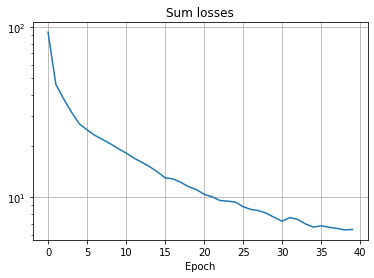

In [217]:
from matplotlib import pyplot as plt

plt.semilogy(all_losses)
plt.grid()
plt.xlabel('Epoch')
plt.title('Sum losses')
plt.show()

In [423]:
model.eval()
evaluator.eval_conll(model, val_loader)

{'precision': 48.170731707317074,
 'recall': 29.422718808193668,
 'f1': 36.53179190751445,
 'n_predicted_entities': 328,
 'n_true_entities': 537}

In [424]:
model.eval()
evaluator.eval_conll(model, test_loader)

{'precision': 48.24120603015076,
 'recall': 31.788079470198674,
 'f1': 38.32335329341318,
 'n_predicted_entities': 398,
 'n_true_entities': 604}

In [425]:
model.eval()
evaluator.eval_conll(model, train_loader)

{'precision': 84.04947916666667,
 'recall': 86.27756738694586,
 'f1': 85.14895020336374,
 'n_predicted_entities': 4608,
 'n_true_entities': 4489}

In [216]:
import pickle
with open('./BiLSTM.bin', 'wb') as fout:
    pickle.dump(model, fout)
with open('./BiLSTM_losses.bin', 'wb') as fout:
    pickle.dump(all_losses, fout)

Качество модели получилось удовлетворительным даже без gradient clipping. Архитектура оказалась чувствительной к выбору вероятности dropout. Увеличение этой вероятности помогло сильно повысить качество. После 40 эпох замтно падение качества из-за переобучения.

## Необучаемый пост-процессинг результата (4 балла).

Для обучения нейросетевой модели разметки используется поэлементная кросс-энтропия. При использовании на этапе инференса функции $\arg \max$ для получения выходной последовательности, мы не можем гарантировать согласованность предсказаний. Для согласованности необходимо вместо $\arg \max$ использовать другие функции получения предсказаний.

В модели CRF для получения предсказаний используется алгоритм Витерби. Напомним, что модель CRF моделирует вероятность последовательности $y$ при условии $x$ линейной моделью с вектором весов $w \in \mathbb{R}^d$, которая после некоторых преобразований записывается следующим образом:
$$
p(y|x, w) = \frac{1}{Z(x, w)} \exp\left( \sum_{i=1}^n \sum_{j = 1}^d w_j f_j(y_{i-1}, y_i, x_i, i) \right) =  \frac{1}{Z(x, w)} \exp\left( \sum_{i=1}^n G_{x, i}[y_{i-1}, y_i] \right)
$$

Модель необучаемого пост-процессинга **подробно описана** в приложении к заданию. Она сводится к следующим шагам.

1. Реализовать модель CRF с двумя признаками:
    
    * Лог-софтмакс выходов модели (выход, соответствующий $y_i$ тэгу для i-го токена будем обозначать $S_{i,y_i}$)    
    
    $$
    f_1(y_{i-1}, y_i, x_i, i) = S_{i,y_i}
    $$
    
    * Логарифмы вероятностей переходов

    $$
    f_2(y_{i-1}, y_i, x_i, i) = \log A[v=y_{i}, u=y_{i-1}] \mathbb{I}[i > 1] \times \log C[v = y_i] \mathbb{I}[i = 1], \quad \text{где:}
    $$

    $$A_{vu} = \frac{\sum_{y}\sum_{i=2}^{|y|} \mathbb{I}[y_{i} = v, y_{i - 1} = u]}{\sum_{y}\sum_{i=2}^{|y|} \mathbb{I}[y_{i-1} = u]}
    $$
    $$
    C_v = \frac{\sum_{y}\mathbb{I}[y_{1} = v]}{\sum_{y}1}
    $$
    
2. Реализовать процедуру получения оптимальной выходной последовательности, используя алгоритм Витерби

3. Подобрать на валидационной выборке веса модели $w_1$ и $w_2$

Для исходной модели, дающей на валидационной и тестовой выборке F1 меру 0.408 и 0.46 соответственно, качество после такого пост-процессинга выросло до 0.461 и 0.493. Заметим, что для тестирования модели не нужно переобучать исходную модель. Для более устойчивого поведения модели, используйте сглаживание матрицы $A$ (добавьте перед нормировкой ко всем значениям одинаковое небольшое число).

**<font color='red'>Задание. Реализуйте требуемую модель, добейтесь улучшения качества на валидации и тесте, сделайте выводы.</font>**

In [433]:
import torch.nn.functional as F

# Алгоритм Витерби. Обработка данных после кросс ентропии. 
class ViterbiPostprocesser:    
    def __init__(self, model, tag_space_size, smoothing=1.0, w=1.0):
        """
        model : torch.nn.Module
            Tagging model
        smoothing : float, constant in add-k-smoothing
        w : feature weight
             Use w for first feature weight and (1 - w) for second feature.
        """
        self.model = model
        self.smoothing = smoothing
        self.w = w
        self.tss = tag_space_size
        
    def fit(self, dataset):
        """
        Fit the model using maximum likelihood method.
        
        dataset: torch.dataset
            One element if pair (sentence, tags) 
        """
        self.A = torch.Tensor().new_full((self.tss, self.tss), self.smoothing)
        self.C = torch.zeros(self.tss)
        for sentence, tags in dataset:
            if len(tags):
                self.C[tags[0]] += 1
            for i in range(1, len(tags)):
                self.A[tags[i], tags[i-1]] += 1
                self.C[tags[i]] += 1
        self.A /= self.A.sum(dim=0)
        self.C /= self.C.sum()
        self.A = self.A.log()
        self.C = self.C.log()
        
    def decode(self, model_logprobs):
        """
        Viterbi decoding for input model output
        
        model_logprobs : torch.tensor
            Shape is (sequence_length, tag_space_size) 
        """
        delta = torch.zeros(model_logprobs.shape)
        s = torch.zeros(model_logprobs.shape)
        delta[0] = self.C + model_logprobs[0]
        for i in range(1, len(delta)):
            for k in range(delta.shape[1]):
                delta[i][k] = (delta[i-1] + (1 - self.w)*self.A[k] + self.w*model_logprobs[i][k]).max()
                s[i][k] = (delta[i-1] + (1 - self.w)*self.A[k] + self.w*model_logprobs[i][k]).argmax()
        prediction = torch.LongTensor(size=(len(model_logprobs),))
        prediction[-1] = delta[-1].argmax()
        for i in range(len(model_logprobs)-1):
            prediction[-i-2] = s[-i-1, prediction[-i-1]]
        return prediction
    
    def predict_for_batch(self, x_batch):
        """
        Returns predictions for x_batch. Use viterbi decoding.
        
        return type: torch.LongTensor
        return shape: (number of samples in batch, number words in sentence.
        
        ----------
        Parameters
        x_batch: torch.LongTensor with shape (number of samples in batch, number words in sentence).
        """
        predictions = torch.LongTensor(x_batch.shape)
        log_probs = F.log_softmax(self.model(x_batch), dim=2)
        for i, lp in enumerate(log_probs):
            predictions[i] = self.decode(lp)
        return predictions

Место для ваших экспериментов:

In [442]:
W = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
val_f1 = []

for w in tqdm(W):
    model.eval()
    VP = ViterbiPostprocesser(model, len(tag_to_idx), w=w)       
    VP.fit(train_dataset)
    score = evaluator.eval_conll(VP, val_loader)
    val_f1.append(score['f1'])

In [443]:
val_f1

[32.20338983050847,
 34.45491251682369,
 36.69250645994832,
 36.523929471032744,
 35.960591133004925,
 35.11269276393831]

In [440]:
W = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
test_f1 = []

for w in tqdm(W):
    model.eval()
    VP = ViterbiPostprocesser(model, len(tag_to_idx), w=w)       
    VP.fit(train_dataset)
    score = evaluator.eval_conll(VP, test_loader)
    test_f1.append(score['f1'])

In [441]:
test_f1

[32.493702770780864,
 38.443396226415096,
 39.542857142857144,
 40.308370044052865,
 39.53241232731138,
 37.06720977596741]